This is a program that will train a model to identify and assign hits to tracks.
Written by Daniel Zurawski & Keshav Kapoor for Fermilab Summer 2017 internship.

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The below code is borrowed from a DS&HEP tutorial.
It is used to graph the histories after fitting a model.

In [2]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple([0.1, 0.1, 0.1])
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = tuple([0, 0, 1])
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

Here, we define a LinearTracker class.
This class is used to load input and output from a .csv file in the correct format for training the model.

In [3]:
class LinearTracker():
    """ An object that classifies particles to tracks after an event. """    
    def __init__(self, dataframe, model=None):
        """ Initialize a LinearTracker.
            @param dataframe - pd.DataFrame - used to pick tracks from.
                The headers should contain: ("id", "z", "r", "phi").
            @param model - keras model - A network model that the tracker will
                use to classify particles.
            @return Nothing
        """
        self.model     = model     # keras model to figure out tracks.
        self.dataframe = dataframe # pandas.DataFrame for picking tracks.
        self.input     = None      # input to train model on.
        self.output    = None      # output to train model on.
    # END function __init__
    
    def load_data(self, num_events, tracks_per_event, track_size, noise_per_event):
        """ Load input and output data from this object's dataframe.
            @param num_events - int - The number of events to generate.
            @param tracks_per_event - int - The number of tracks per event.
            @param track_size - int - The number of hits per track.
            @param noise_per_event - int - The number of hits with no track.
            @return Nothing
                However, self.input and self.output become numpy arrays.
                self.input is collection of hits of shape:
                    (num_events, hits_per_event, 3)
                self.output is list of probability matrices of shape:
                    (num_events, hits_per_event, tracks_per_event)
        """
        hits_per_event = (track_size * tracks_per_event) + noise_per_event
        labels = ["phi", "r", "act_z"]
        groups = self.dataframe[["id", "r", "phi", "act_z"]].groupby("id")
        goods  = groups.filter(lambda track: len(track) == track_size)
        bads   = groups.filter(lambda track: len(track) != track_size)
        
        # Populate input and output with data.
        goods_group = [g[1] for g in list(goods.groupby("id"))]
        self.input  = np.zeros((num_events, hits_per_event, len(labels)))
        self.output = np.zeros((num_events, hits_per_event, tracks_per_event))
        for n in range(num_events):
            # Retrieve a sample of tracks.
            tracks = random.sample(goods_group, tracks_per_event)
            
            # Make a mapping from track ID to index within a matrix.
            T2I = self.__get_matrix_map__(tracks) # Track to Index
            
            # Make some noise hits to add.
            noise  = bads.sample(noise_per_event)
            hits   = pd.concat(tracks + [noise]).sort_values(labels)
            
            self.__populate_input__(hits, labels, n)
            self.__populate_output__(hits, T2I, n)
    # END FUNCTION load_data
    
    def __populate_input__(self, hits, labels, event_index):
        self.input[event_index, :] = hits[labels].values
    # END FUNCTION __populate_input__
    
    def __populate_output__(self, hits, mapping, event_index):
        for t, track_ID in enumerate(hits["id"]):
            index = mapping.get(track_ID)
            if index is not None:
                self.output[event_index, t, index] = 1
    # END FUNCTION __populate_output__
        
    def __get_matrix_map__(self, tracks):
        L = pd.concat([T.sort_values(["r"]).head(1) for T in tracks])
        L.sort_values(["phi", "act_z"], inplace=True)
        return dict((hit, idx) for idx, hit in enumerate(L["id"]))
    # END FUNCTION __get_matrix_map__
# END CLASS LinearTracker

Below is how to create a LinearTracker and how to load data into it. It is important to note that after construction, a LinearTracker must call its load_data() function with user specifications for how data should be loaded.

If you get a ValueError describing how the population is not large enough for the sample, then that means that the data
loaded in from the .csv file does not contain enough tracks of size 'track_size'. Try to either load in a larger
population or change the 'track_size' variable to a different positive integer.

In [4]:
filename  = ('corrected5k_data.csv')
dataframe = pd.read_csv(filename)
tracker   = LinearTracker(dataframe)

Load the data into the input and output member variables of LinearTracker.

In [5]:
np.random.seed(7)
tracker.load_data(num_events=512, tracks_per_event=5, track_size=4, noise_per_event=5)
print("Ding! All done.")

Ding! All done.


Let's take a look at the input and output training data.

In [12]:
from IPython.display import display,HTML

def multi_column_df_display(list_dfs, cols=2):
    """ Code by David Medenjak responding to StackOverflow question found here:
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        Displays a list of dataframes in IPython as a table with cols number of columns.
    """
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))
# END FUNCTION multi_column_df_display

input_cols  = ["phi", "r", "act_z"]
output_cols = ["T{}".format(i) for i in range(tracker.output.shape[2])]
show_max    = 2

if show_max is not None and show_max > 0 and show_max < len(tracker.input):
    print("Displaying the first {} inputs and outputs.".format(show_max))
    input_frames  = [pd.DataFrame(data=tracker.input[i], columns=input_cols) for i in range(show_max)]
    output_frames = [pd.DataFrame(data=tracker.output[i].astype(int), columns=output_cols) for i in range(show_max)]
else:
    print("Displaying all of input and output.")
    input_frames  = [pd.DataFrame(data=matrix, columns=input_cols)  for matrix in tracker.input]
    output_frames = [pd.DataFrame(data=matrix.astype(int), columns=output_cols) for matrix in tracker.output]
    
df_list  = []
for i in range(len(input_frames)):    
    df_list.append(input_frames[i])
    df_list.append(output_frames[i])

print("Input shape:  {}".format(tracker.input.shape))
print("Output shape: {}".format(tracker.output.shape))
multi_column_df_display(df_list)

Displaying the first 2 inputs and outputs.
Input shape:  (500, 25, 3)
Output shape: (500, 25, 5)


,phi,r,act_z
0,0.539617,40.0,123.024921
1,1.034402,100.0,182.271693
2,1.921933,40.0,15.427553
3,1.921933,70.0,35.448040
4,1.921933,100.0,55.468528
5,1.921933,130.0,75.489015
6,4.409135,40.0,-27.926506
7,4.409135,70.0,-75.352364
8,4.409135,100.0,-122.778223
9,4.409135,130.0,-170.204082


Let's now try to load a model into our tracker.

In [13]:
import keras
from keras.layers import Dense, Activation, LSTM, Dropout, Flatten, TimeDistributed
from keras.models import Sequential
from keras.optimizers import SGD

In [14]:
input_shape = tracker.input[0].shape # Shape of an event.
output_shape = len(tracker.output[0][0]) # Number of tracks per event
print("Input Shape:  {}".format(input_shape))
print("Output Shape: {}".format(output_shape))

kinit = 'uniform' # kernel_initializer
act   = 'relu' # activation
opt   = 'rmsprop' # optimizer
batch_size = 32
epochs = 512
valsplit = 0.25

tracker.model = Sequential()
tracker.model.add(LSTM(64, return_sequences=True, input_shape=input_shape, dropout=.2, recurrent_dropout=0.2))
tracker.model.add(LSTM(64, return_sequences=True, dropout=.2, recurrent_dropout=.2))
tracker.model.add(LSTM(64, return_sequences=True, dropout=.2, recurrent_dropout=.2))
tracker.model.add(Dense(output_shape, activation='softmax'))

tracker.model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
tracker.model.summary()

Input Shape:  (25, 3)
Output Shape: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 25, 64)            17408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 25, 64)            33024     
_________________________________________________________________
lstm_6 (LSTM)                (None, 25, 64)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 25, 5)             325       
Total params: 83,781
Trainable params: 83,781
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist = tracker.model.fit(tracker.input, tracker.output, epochs=epochs, batch_size=batch_size,
                         verbose=0, validation_split=valsplit,
                         callbacks=[keras.callbacks.ModelCheckpoint(filepath='simple.h5', verbose=0)])
print("Ding! All done.")

Ding! All done.


In [16]:
print(tracker.model.predict(tracker.input, batch_size=500, verbose=0))

[[[  9.95200038e-01   6.19456288e-04   1.46840792e-03   1.05138472e-03
     1.66080112e-03]
  [  9.99999285e-01   6.74547280e-08   1.76719865e-07   1.34504859e-07
     3.53803415e-07]
  [  9.99991417e-01   2.41498651e-06   1.67186488e-06   2.28057456e-06
     2.30851151e-06]
  ..., 
  [  4.92570029e-09   1.54201791e-06   1.71377494e-07   4.04687580e-06
     9.99994278e-01]
  [  2.61960875e-09   2.38278858e-06   4.79496940e-08   5.45022203e-06
     9.99992132e-01]
  [  1.67215628e-08   1.78655898e-06   2.27167636e-08   4.04059347e-06
     9.99994159e-01]]

 [[  9.99830604e-01   1.63694549e-05   5.73906364e-05   3.94247108e-05
     5.61701963e-05]
  [  9.99997139e-01   3.12151457e-07   6.57592636e-07   5.36538494e-07
     1.22563790e-06]
  [  1.00000000e+00   2.12484230e-09   2.79687884e-10   3.52705198e-10
     3.22057114e-09]
  ..., 
  [  5.16133936e-09   1.08334416e-06   5.54292257e-08   1.12088662e-06
     9.99997735e-01]
  [  2.51591237e-09   9.65531058e-07   8.50838155e-09   7.3740

It's time to graph the history of the neural network.

480/500 [===========================>..] - ETA: 0sTest score: 2.47811999579e-05
Test accuracy: 0.837919997692


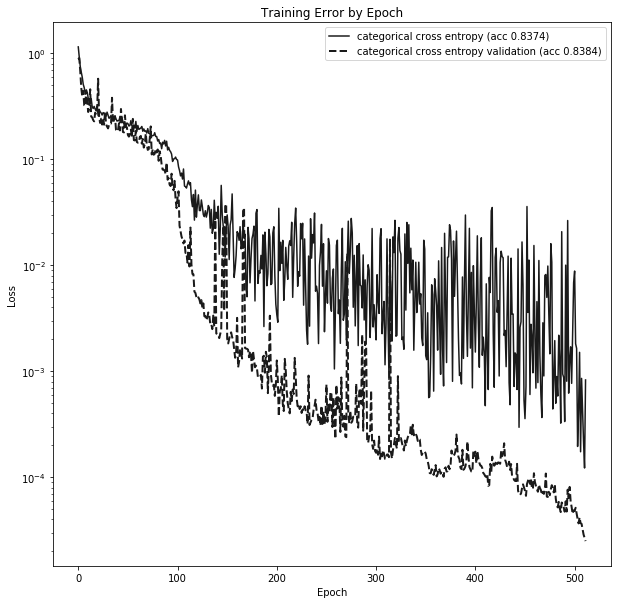

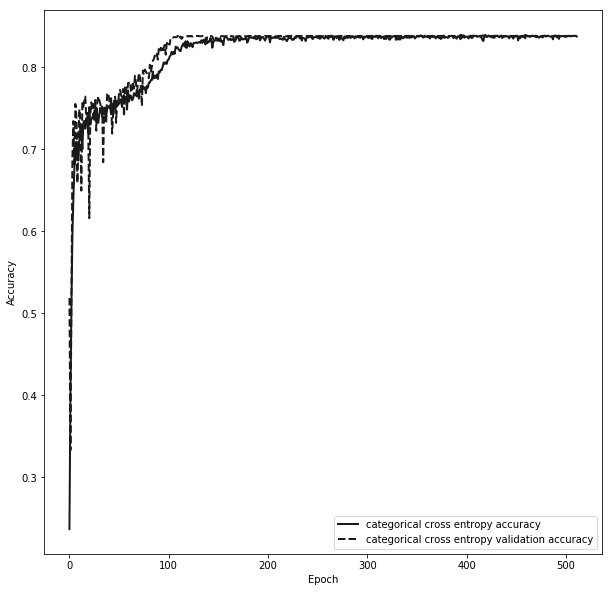

In [17]:
score, acc = tracker.model.evaluate(tracker.input, tracker.output, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
show_losses([("categorical cross entropy", hist)])